# Egg Card Indexing from Standard Cards

We go through the general steps to extract entity infromation from egg cards.

The entities are:
1. Registration number
1. Species
1. Locality
1. Collector
1. Date
1. Set mark
1. No. Eggs

There is also a large box at the bottom of the card for additional comments.

#### General Imports

In [1]:
import os
import matplotlib.pyplot as plt
import re

#### Paths

In [2]:
output_dir = 'outputs/'
image_path = '/home/arias1/Documents/GitHub/egg_cards/Images_new/Drawer_2/resized/002-0013.png'

## Step 1: Extracting boxes and textboxes

1) __Box outlines__: We start by getting outlines of boxes within egg cards by using basic contour extraction tricks. We then _correct_ the resulting boxes in order for them to fit the _standard_ egg card layout. This step relies on the function `get_boxes_and_labels` from ___box_correction_functions.py___.
2) __Textboxes__: Using CRAFT to find coordinates of textboxes around all text. This step uses `get_craft_textboxes` from ___text_extraction_functions.py___.
3) __Index Matching__: Match the index of each textbox, to the (category) box it is within. In the standard layout, there are 8 category boxes (including the additional text box at the bottom). This step uses `get_box_index_for_textboxes` from ___source_functions.py___.

In [4]:
from text_extraction_functions import get_boxes_and_textboxes_and_index

In [6]:
boxes_ref, textboxes, inds_dict, img_sk = get_boxes_and_textboxes_and_index(image_path, output_dir)

## Step 2: Categorisation & OCR

1) __Registration Number__: Looks for a collection of numbers in the vertical box. If it hasn't found it, it also looks within the specie box (top horizontal box) as it sometimes placed there. Main function `get_reg_number` in ___text_extraction_functions.py___.
2) __Species__: Get species+ information using GBIF API.
    * `find_species_from_text` from ___post_processing_functions.py___ -- locates the specie from the text within the specie category box and extracts GBIF data.
    * `get_taxon_info` from ___post_processing_fuctions.py___ -- Extracts required fields (e.g., specie, genera, family) from GBIF results and reformats as dictionary.
3) __Locality__, __Collector__, __Date__, __Set Mark__, __No. Eggs__: These entities followed similar steps;
    * `get_text_from_category_box` from ___text_extraction_functions.py___ to extract text from specific category box.
    * `remove_category_from_text` from ___text_extraction_functions.py___ to remove the category name from the text e.g., "No. Of Eggs 2" will result in "2" and so on.
4) __Other Text__: Extract text from the additional notes section of egg card using `_get_text_from_other_box` from ___text_extraction_functions.py___.
    * `refine_boxes` from ___source_functions.py___ to combine textboxes that are close to each other.
    * `text_from_multiple_textboxes` from ___text_extraction_functions.py___ to extract text.

In [7]:
from text_extraction_functions import get_all_category_text

In [8]:
all_info = get_all_category_text(boxes_ref, textboxes, inds_dict, img_sk)

In [9]:
all_info

{'registrationNumber': '1859.3.25.64',
 'cardSpecies': 'EUDYPTES CHRYSOCOME',
 'order': 'Sphenisciformes',
 'family': 'Spheniscidae',
 'genus': 'Eudyptes',
 'species': 'Eudyptes chrysocome',
 'canonicalName': 'Eudyptes chrysocome',
 'locality': 'Falkland Islands',
 'collector': 'Capt Abbott Gould Collection',
 'date': '',
 'setMark': '',
 'noOfEggs': '1',
 'remainingText': "Not now in collection, Listed in Seebohm's MS Cat  but not in Oates  pom il "}

## Box / Textboxes Plot

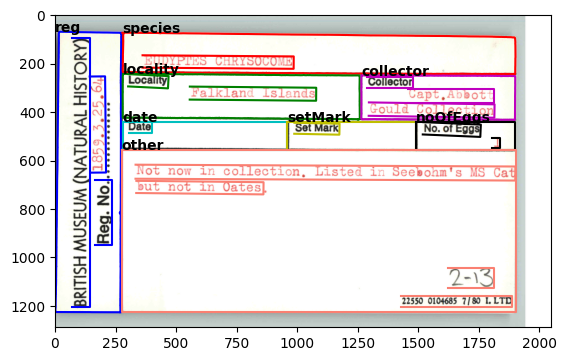

In [10]:
fig,ax = plt.subplots()
ax.imshow(img_sk)

cols = ['b','r','g','m','c','y','k','salmon','grey','brown','darkgreen']
labels = ['reg','species','locality','collector','date','setMark','noOfEggs','other']


for i,l in enumerate(labels):
    ax.plot(boxes_ref[l][0],boxes_ref[l][1],color=cols[i])
    ax.text(min(boxes_ref[l][0]),min(boxes_ref[l][1]),l,color='k',weight='bold')
    for j in list(inds_dict.keys()):
        if inds_dict[j] == i:
            b = textboxes[j]
            ax.plot(b[:,0],b[:,1],color=cols[i])